In [61]:
# Gonna look at for a random signal
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [ ]:
diameter = 0.125
period = 304e-6
min_wavelength = 580e-9

In [ ]:
# i'm sorta kinda limited by N here.  yeah can't really get around it cleverly.
# can't even reduce dx... gonna try doing without FFT.
# even without FFT, there isn't a way to do it because cutting stuff off introduces high freqs
# and reduces the real resolution of the frequency information.

# Parameters
N_x = 1024                         # Number of physical space samples
N_f = 2048                         # Number of frequency samples
dx = 0.001 * 10e-9                 # Physical spacing
x_vals = np.arange(N_x) * dx      # Real space points

max_wavelength = min_wavelength + N_x*dx

# Frequency domain
max_spec_freq = (np.sqrt(2)/period) * (diameter/min_wavelength)  
low_max_spec_freq = (np.sqrt(2)/period) * (diameter/max_wavelength)

f_min = -2 * max_spec_freq
f_max = 2 * max_spec_freq
freqs = np.linspace(f_min, f_max, N_f)
df = freqs[1] - freqs[0]

# Generate spectrum with random amplitudes and phases (band-limited)
key = jr.PRNGKey(19)
amp_key, phase_key = jr.split(key)
amp = jr.normal(amp_key, shape=(N_f,))
phase = jr.uniform(phase_key, shape=(N_f,), minval=0.0, maxval=2*np.pi)
spectrum = amp * np.exp(1j * phase)

# make signal real
half = N_f // 2
spectrum = spectrum.at[:half].set(np.conj(spectrum[-1:half-1:-1]))

# Apply band-pass mask
band_mask = (np.abs(freqs) <= max_spec_freq)
spectrum_filtered = spectrum * band_mask

low_band_mask = (np.abs(freqs) <= low_max_spec_freq)
spectrum_filtered_low = spectrum * low_band_mask

# Construct kernel matrix: shape (N_x, N_f)
# Each row i corresponds to e^{2π i f_k x_i}
kernel = np.exp(2j * np.pi * np.outer(x_vals, freqs))  # shape (1024, 2048)

# Integrate over frequency domain (Riemann sum approximation)
signal = kernel @ spectrum * df  # shape (1024,)

signal_filtered = kernel @ spectrum_filtered * df

signal_filtered_low = kernel @ spectrum_filtered_low * df

# Optional: make real if spectrum is conjugate-symmetric
signal_real = signal.real

signal_filtered_real = signal_filtered.real

signal_filtered_low_real = signal_filtered_low.real


if np.min(signal_real) <= 0:
    signal_filtered_real += -2*np.min(signal_real)
    signal_filtered_low_real += -2*np.min(signal_real)
    signal_real += -2*np.min(signal_real)

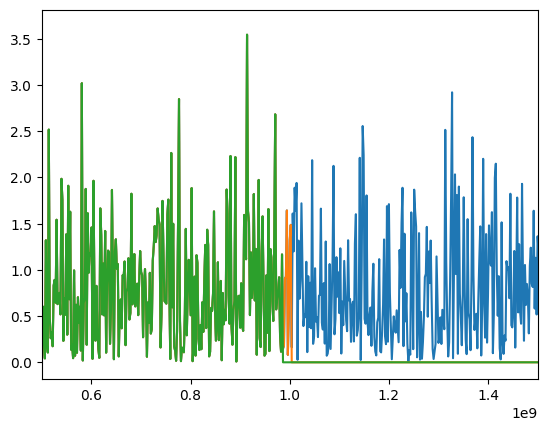

In [152]:
plt.plot(freqs, np.abs(spectrum))
plt.plot(freqs, np.abs(spectrum_filtered))
plt.plot(freqs, np.abs(spectrum_filtered_low))
plt.xlim(0.5e9, 1.5e9)
plt.show()

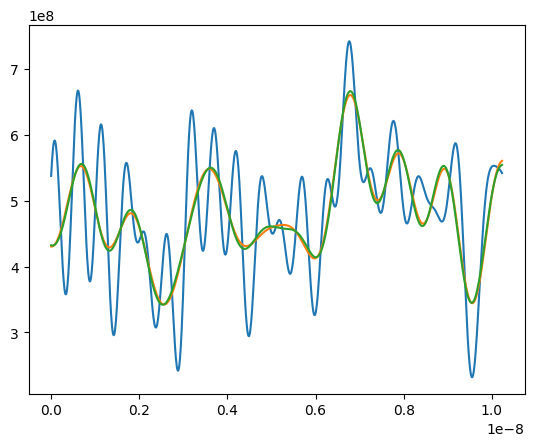

In [153]:
plt.plot(x_vals,signal_real)
plt.plot(x_vals,signal_filtered_real)
plt.plot(x_vals,signal_filtered_low_real)
plt.show()

In [154]:
wavelengths = np.linspace(min_wavelength, max_wavelength, N_x)

nyquist_sample_interval = 1/(2*max_spec_freq)

sample_interval = 0.4*nyquist_sample_interval #quarter nyquist

n_wavelengths_sample = int(np.ceil(((N_x+2)*dx)/sample_interval))

print(n_wavelengths_sample)

wavelengths_sample = np.linspace(min_wavelength - sample_interval, min_wavelength + sample_interval*(n_wavelengths_sample-1), n_wavelengths_sample)
print(wavelengths_sample[-1])

weights_initial = np.ones(n_wavelengths_sample) # log weights, but init at 1

flux = 100*(2.909*10**7)/11
difference = np.pi * 0.348
flux_renorm = flux/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal_real)

source_filtered = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal_filtered_real)

source_model = dl.PointSource(wavelengths_sample, flux=flux_renorm, weights=weights_initial)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 64
psf_pixel_scale = 0.375
oversample = 4 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

center_wl = 585e-9

telescope = dl.Telescope(optics, source)
telescope_filtered = dl.Telescope(optics, source_filtered)
telescope_model = dl.Telescope(optics, source_model)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_filtered = dlT.SideLobeTelescope(telescope_filtered, period, difference)
sidelobescope_model = dlT.SideLobeTelescope(telescope_model, period, difference)

sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, downsample = oversample)
sidelobe_filtered_raw = sidelobescope_filtered.model_sidelobes(center_wavelength = center_wl, downsample=oversample)

sidelobe_poisson = jr.poisson(jr.PRNGKey(0), sidelobe_raw)

52
5.9017367e-07
Model time: 16.6230 seconds.
Model time: 16.2316 seconds.


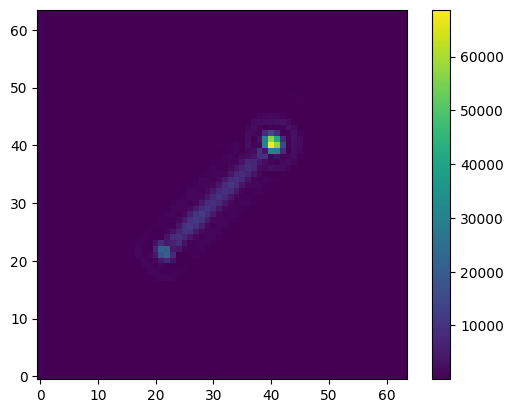

In [155]:
plt.imshow(np.abs(sidelobe_raw - sidelobe_filtered_raw), origin='lower')
plt.colorbar()
plt.show()
# WOW. So you can clearly see that there is no difference (except on the edges) between sending a filtered signal
# and another higher frequency signal in.
# The maths actually works out!!